**<h2>Code to extract data and generate statistical graphs from Google Earth Engine**
**<h4>César Iván Álvarez**
**<h5>Geospatial Data Scientist**

**<h2>Installing, loading and credential of libraries<h2>**

In [1]:
#Instalación de bibliotecas necesarias
!pip install geopandas rasterio geemap PyCRS forum

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.2/269.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.8 MB/s eta 0:00:00
  Created wheel for PyCRS: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=efb65b9e293b6cd6eb377df84a89811ca837f5874ddbbc78a50f466295477581
  Stored in directory: /root/.cache/pip/wh

In [2]:
#GEE Libraries - Installing using Conda
import ee #GEE library
# Trigger the authentication flow.
ee.Authenticate()

In [3]:
from google.colab import drive #Mount Google Drive in your colab
drive.mount('/content/drive')

Mounted at /content/drive


**<h2>Import Libraries<h2>**

In [4]:
import geopandas as gpd
import geemap
#import rasterio
#from rasterio.mask import mask
import numpy as np
import pandas as pd
import os
import pycrs

ee.Initialize(project='cesarivan')# Initialize the EE library.

**<h2>Define Input Parameters (Dates and attribute to filter areas)<h2>**

In [5]:
area = '/content/drive/My Drive/CesarIvan/ICARDA/01_SHAPEFILES/MOROCCO_BOUNDARY/MOROCCO_BOUNDARIES.shp' # Shapefile URL
selection = 'VALUE' #Name of the attribute field to filter
output_dir = '/content/drive/My Drive/CesarIvan/ICARDA/03_TABLES/MOROCCO_RS'# Define the output directory on Google Drive
export_folder = '/content/drive/My Drive/CesarIvan/ICARDA/04_IMAGES/MOROCCO'# Define the output directory on Google Drive
year_since = 2023
year_to = 2024

# Load the polygon shapefile
shape = gpd.read_file(area)
AOI_total = geemap.shp_to_ee(area)

**<h2>Dataset construction from GEE extraction by polygon<h2>**

In [ ]:
# Define columns and scale
attable = pd.DataFrame(shape, columns=[selection])
columns = ["Area", "Year", "Month", "NDVI", "NDWI","LST_C", "M_Temperature_C", "MAX_Temperature_C", "Min_Temperature_C", "Sum_Rainfall_mm"]

# Initialize rstable with specific dtypes
rstable = pd.DataFrame(columns=columns, dtype=float)
scale = 30000


year_since = 2023
year_to = 2024
month_since = 1
month_to = 13

for year in range(year_since, year_to):
    for month in range(month_since, month_to):
        # Filter dates for each month
        start_date = f'{year}-{month:02d}-01'
        if month == 12:
            end_date = f'{year+1}-01-01'
        else:
            end_date = f'{year}-{month+1:02d}-01'

        modis_ndvi = ee.ImageCollection('MODIS/061/MOD13Q1') \
                    .filterDate(start_date, end_date) \
                    .filterBounds(AOI_total) \
                    .select('NDVI')

        modis_ndwi = ee.ImageCollection('MODIS/MCD43A4_006_NDWI') \
                    .filterDate(start_date, end_date) \
                    .filterBounds(AOI_total) \
                    .select('NDWI')

        modis_lst = ee.ImageCollection('MODIS/061/MOD11A1') \
                    .filterDate(start_date, end_date) \
                    .filterBounds(AOI_total) \
                    .select('LST_Day_1km')

        era5_2mt = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')\
                    .filterDate(start_date, end_date)\
                    .filterBounds(AOI_total)

        for i in range(len(attable.index)):
            namarea = attable.iloc[i, 0]
            AOI = AOI_total.filter(ee.Filter.eq(selection, namarea))

            ndvi_modis = modis_ndvi.median().clip(AOI).multiply(0.0001)
            ndwi_modis = modis_ndwi.median().clip(AOI)
            lst_modis = modis_lst.median().clip(AOI).multiply(0.02).subtract(273.15)
            temp_med_era5 = era5_2mt.median().select('temperature_2m').clip(AOI).subtract(273.15)
            temp_max_era5 = era5_2mt.median().select('temperature_2m_max').clip(AOI).subtract(273.15)
            temp_min_era5 = era5_2mt.median().select('temperature_2m_min').clip(AOI).subtract(273.15)
            prec_era5 = era5_2mt.median().select('total_precipitation_sum').clip(AOI).multiply(1000)

            stats_ndvi = ndvi_modis.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=AOI.geometry(),
                scale=scale,
                maxPixels=1e13
            ).get('NDVI').getInfo()

            stats_ndwi = ndwi_modis.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=AOI.geometry(),
                scale=scale,
                maxPixels=1e13
            ).get('NDWI').getInfo()

            stats_lst = lst_modis.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=AOI.geometry(),
                scale=scale,
                maxPixels=1e13
            ).get('LST_Day_1km').getInfo()

            statstempmed = temp_med_era5.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=AOI.geometry(),
                scale=scale,
                maxPixels=1e13
            ).get('temperature_2m').getInfo()

            statstempmax = temp_max_era5.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=AOI.geometry(),
                scale=scale,
                maxPixels=1e13
            ).get('temperature_2m_max').getInfo()

            statstempmin = temp_min_era5.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=AOI.geometry(),
                scale=scale,
                maxPixels=1e13
            ).get('temperature_2m_min').getInfo()

            statsprec = prec_era5.reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=AOI.geometry(),
                scale=scale,
                maxPixels=1e13
            ).get('total_precipitation_sum').getInfo()

            # Collect the data and include the month
            data = [namarea, year, month, stats_ndvi, stats_ndwi, stats_lst, statstempmed, statstempmax, statstempmin, statsprec]

            # Only concatenate if data is not all NaN
            if not all(pd.isna(data)):
                new_row = pd.DataFrame([data], columns=columns)
                rstable = pd.concat([rstable, new_row], ignore_index=True)

    # Save the DataFrame to an Excel file in Google Drive after each year
    output_path = os.path.join(output_dir, f'{year}.xlsx')
    rstable.to_excel(output_path, index=False)

    # Reinitialize rstable for the next year
    rstable = pd.DataFrame(columns=columns, dtype=float)

EEException: Dictionary.get: Dictionary does not contain key: 'NDWI'.

**<h2>Merges all the Excel files by year<h2>**

In [6]:
excel_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.xlsx') and f.startswith('20')]
output_file = 'rs_2001_2022.xlsx'

# Paso 5: Leer y combinar los archivos Excel en un solo DataFrame
dataframes = []
for files in excel_files:
    df = pd.read_excel(files)
    dataframes.append(df)

df_rs = pd.concat(dataframes, ignore_index=True)
saved_path = os.path.join(output_dir, output_file)
df_rs.to_excel(saved_path, index=False)

df_rs

,Area,Year,Month,NDVI,NDWI,LST_C,M_Temperature_C,MAX_Temperature_C,Min_Temperature_C,Sum_Rainfall_mm
0,0,2001,1,0.315930,-0.010839,19.758626,14.177259,22.465235,7.233528,93.445788
1,1,2001,1,0.551250,-0.041708,10.710000,8.369062,16.432031,0.842950,2.781357
2,2,2001,1,0.223738,-0.081390,16.230064,8.789530,19.585869,0.355433,3406.099814
3,3,2001,1,0.492597,-0.035668,15.195392,10.624490,20.308492,2.219641,6512.890999
4,4,2001,1,0.335839,-0.037659,13.158047,7.442488,17.976316,-1.572803,3730.539467
...,...,...,...,...,...,...,...,...,...,...
511,3,2022,12,0.376749,-0.103270,17.726136,14.101289,23.612372,5.142029,9740.469445
512,4,2022,12,0.324299,-0.089828,15.088750,10.565496,19.881415,1.993787,5774.251892
513,5,2022,12,0.543142,-0.070962,15.532456,12.221013,20.377192,3.339977,63.344561
514,6,2022,12,0.309039,-0.063837,18.817588,14.764219,24.389617,5.888627,95.409444


In [8]:
df_rs.columns = ['Area', 'Year', 'Month', 'NDVI', 'NDWI', 'LST (°C)', 'Median Temperature (°C)', 'Maximum Temperature (°C)', 'Minimum Temperature (°C)', 'Rainfall (mm)']
df_rs = df_rs[~df_rs['Area'].isin([0, 1])]

# Definir las nuevas categorías
new_categories = {
    2: "Shrublands",
    3: "Croplands",
    4: "Grasslands",
    5: "Forest",
    6: "Urban",
    7: "Barren Land"
}

# Crear la nueva columna 'Land Use' basada en el mapeo de 'Area'
df_rs['Land Use'] = df_rs['Area'].map(new_categories)
df_rs

<ipython-input-8-2668f85f8396>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rs['Land Use'] = df_rs['Area'].map(new_categories)


,Area,Year,Month,NDVI,NDWI,LST (°C),Median Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Rainfall (mm),Land Use
2,2,2001,1,0.223738,-0.081390,16.230064,8.789530,19.585869,0.355433,3406.099814,Shrublands
3,3,2001,1,0.492597,-0.035668,15.195392,10.624490,20.308492,2.219641,6512.890999,Croplands
4,4,2001,1,0.335839,-0.037659,13.158047,7.442488,17.976316,-1.572803,3730.539467,Grasslands
5,5,2001,1,0.579030,-0.068406,12.854255,9.713678,18.248301,0.664772,33.430504,Forest
6,6,2001,1,0.406120,0.005270,17.652117,11.414020,20.978529,3.449165,54.851146,Urban
...,...,...,...,...,...,...,...,...,...,...,...
511,3,2022,12,0.376749,-0.103270,17.726136,14.101289,23.612372,5.142029,9740.469445,Croplands
512,4,2022,12,0.324299,-0.089828,15.088750,10.565496,19.881415,1.993787,5774.251892,Grasslands
513,5,2022,12,0.543142,-0.070962,15.532456,12.221013,20.377192,3.339977,63.344561,Forest
514,6,2022,12,0.309039,-0.063837,18.817588,14.764219,24.389617,5.888627,95.409444,Urban


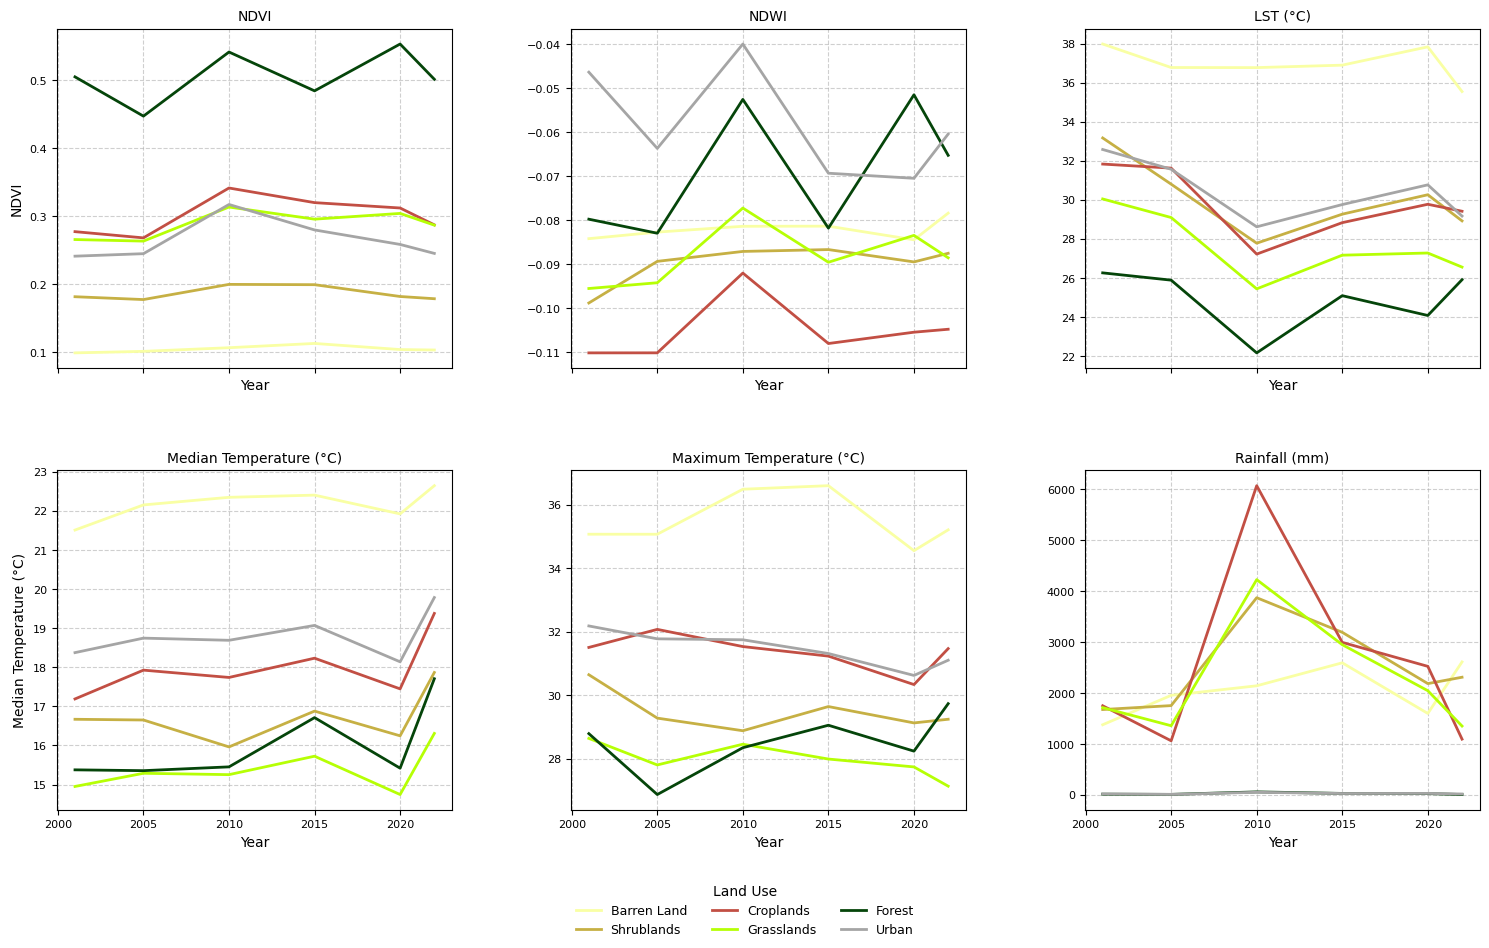

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Define the colors for each land use category
category_colors = {
    "Barren Land": "#f9ffa4",
    "Shrublands": "#c6b044",
    "Croplands": "#c24f44",
    "Grasslands": "#b6ff05",
    "Forest": "#05450a",
    "Urban": "#a5a5a5",
}

# Filter columns to exclude Area, Year, Month, and Land Use
columns_to_plot = [col for col in df_rs.columns if col not in ["Area", "Year", "Month", "Land Use", "Minimum Temperature (°C)"]]

# Calculate the number of rows and columns needed for the subplots
num_plots = len(columns_to_plot)
num_cols = 3  # Fixed number of columns
num_rows = math.ceil(num_plots / num_cols)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True)
axes = axes.flatten()

# Plot each column
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    # Group by Year and Land Use and calculate the mean for the selected column
    land_use_summary = df_rs.groupby(['Year', 'Land Use'])[column].median().reset_index()

    # Pivot the data for easier plotting
    pivot_df = land_use_summary.pivot(index='Year', columns='Land Use', values=column)

    # Plot each land use category
    for land_use, color in category_colors.items():
        if land_use in pivot_df.columns:
            ax.plot(
                pivot_df.index, pivot_df[land_use],
                label=land_use, color=color, linewidth=2
            )

    # Customize each subplot
    ax.set_title(f"{column}", fontsize=10)
    ax.set_xlabel("Year", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add ylabel for only the leftmost plots
    if i % num_cols == 0:
        ax.set_ylabel(column, fontsize=10)

# Hide unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend below all plots
handles = [plt.Line2D([0], [0], color=color, lw=2, label=land_use) for land_use, color in category_colors.items()]
fig.legend(handles=handles, title="Land Use", loc='lower center', ncol=3, fontsize=9, frameon=False)

# Adjust the layout
plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Leave space for the legend
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between plots
plt.show()



**<h2>Time Series and Correlation Graphs<h2>**

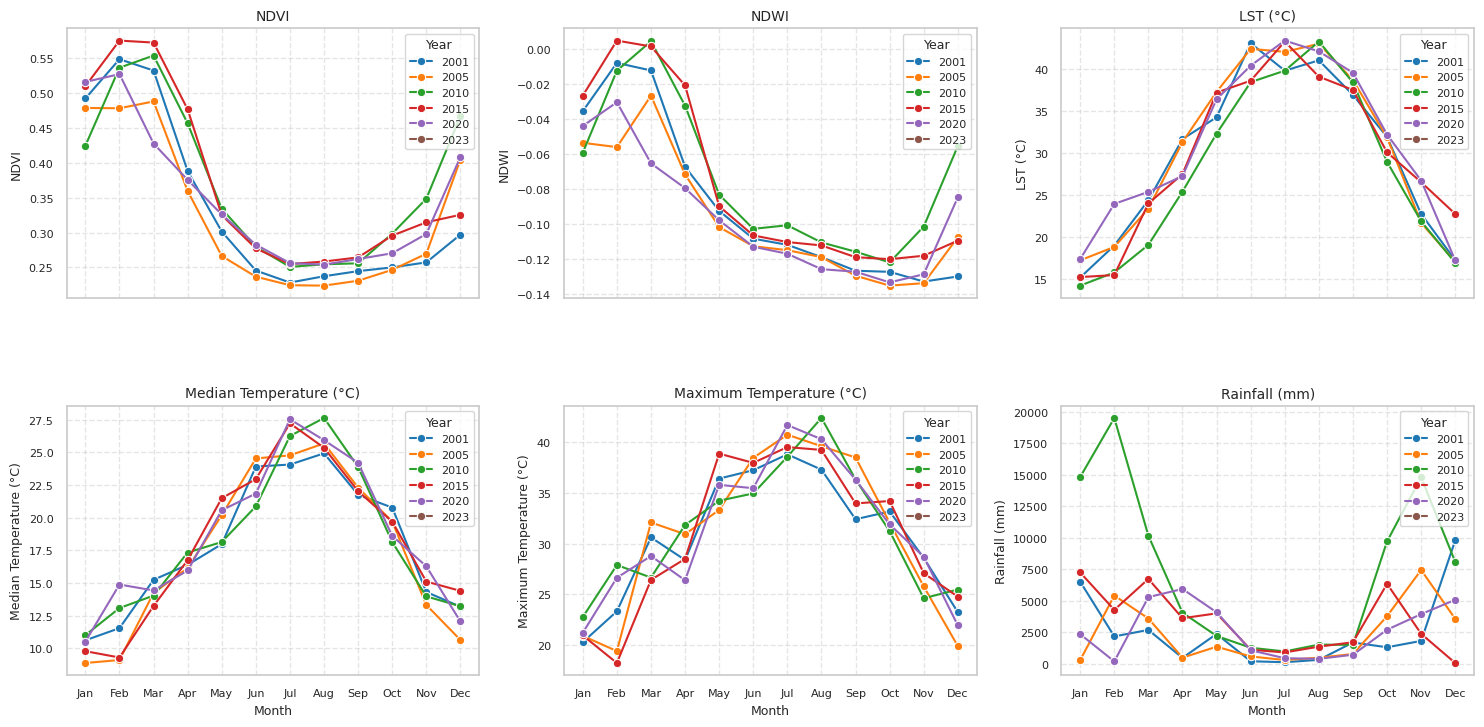

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que la columna "Year" sea de tipo string
df_rs = df_rs.copy()
df_rs['Year'] = df_rs['Year'].astype(str)

# Filtrar el dataset para incluir solo los años deseados y la categoría "Croplands"
years_to_plot = ['2001', '2005', '2010', '2015', '2020', '2023']
df_filtered = df_rs[df_rs['Land Use'] == 'Croplands']

# Variables a graficar (excluyendo "Area", "Year", "Month" y "Land Use")
variables_a_graficar = [col for col in df_rs.columns if col not in ['Area', 'Year', 'Month', 'Land Use', 'Minimum Temperature (°C)']]

# Configuración del estilo de los gráficos
sns.set(style="whitegrid")

# Crear subplots con 3 columnas y suficientes filas para las variables
num_vars = len(variables_a_graficar)
num_cols = 3
num_rows = (num_vars + num_cols - 1) // num_cols  # Calcular filas necesarias
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8), sharex=True, sharey=False)

# Asegurar que los subplots sean iterables
axes = axes.flatten()

# Crear la paleta de colores para los años
colors = sns.color_palette("tab10", len(years_to_plot))

# Generar gráficos para cada variable
for i, variable in enumerate(variables_a_graficar):
    ax = axes[i]
    sns.lineplot(
        data=df_filtered,
        x='Month',
        y=variable,
        hue='Year',
        hue_order=sorted(years_to_plot),
        palette=colors,
        marker='o',
        ax=ax
    )
    ax.set_title(f'{variable}', fontsize=10)
    ax.set_xlabel('Month', fontsize=9)
    ax.set_ylabel(variable, fontsize=9)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        fontsize=8
    )
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Year', fontsize=8, title_fontsize=9, loc='upper right')  # Leyenda más pequeña y ajustada

# Eliminar subplots vacíos si hay menos de 6 variables
for j in range(num_vars, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para reducir altura
plt.tight_layout(rect=[0, 0.02, 1, 0.95])  # Ajustar rect para evitar superposición
plt.subplots_adjust(hspace=0.4)  # Reducir el espacio entre filas

# Mostrar los gráficos
plt.show()


In [14]:
df_filtered

,Area,Year,Month,NDVI,NDWI,LST (°C),Median Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Rainfall (mm),Land Use
3,3,2001,1,0.492597,-0.035668,15.195392,10.624490,20.308492,2.219641,6512.890999,Croplands
11,3,2001,2,0.549006,-0.008129,19.006964,11.556437,23.347932,3.200051,2168.147749,Croplands
19,3,2001,3,0.532682,-0.012447,24.411717,15.250512,30.608215,6.053414,2683.160755,Croplands
27,3,2001,4,0.388172,-0.067400,31.702697,16.398796,28.394650,7.182346,459.903300,Croplands
35,3,2001,5,0.301359,-0.092565,34.301245,17.977289,36.397189,6.683253,2365.074970,Croplands
...,...,...,...,...,...,...,...,...,...,...,...
483,3,2022,8,0.244358,-0.115149,41.693546,25.820037,39.877064,15.490681,269.413679,Croplands
490,3,2022,9,0.241252,-0.124084,37.027461,22.427478,35.710086,12.832146,962.731177,Croplands
497,3,2022,10,0.241806,-0.115565,31.556847,22.443397,33.999358,12.426428,1273.454830,Croplands
504,3,2022,11,0.265496,-0.125977,26.500281,17.293137,28.567526,6.091807,1174.168098,Croplands


In [19]:
df_median = df_filtered.groupby('Year').median(numeric_only=True).reset_index()

# Asegurarse de que la columna 'Year' sea de tipo entero
df_median['Year'] = df_median['Year'].astype(int)

# Diccionario con los valores de Cropland Area
cropland_area = {
    2001: 10,
    2005: 11.7,
    2010: 13.5,
    2015: 12.9,
    2020: 10.7,
    2022: 10,
}

# Agregar la columna "Cropland Area" al DataFrame df_median
df_median['Cropland Area'] = df_median['Year'].map(cropland_area)

# Mostrar el resultado
df_median


,Year,Area,Month,NDVI,NDWI,LST (°C),Median Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Rainfall (mm),Cropland Area
0,2001,3.0,6.5,0.277061,-0.110161,31.825857,17.188043,31.503456,6.932799,1747.870034,10.0
1,2005,3.0,6.5,0.267896,-0.110154,31.618439,17.924495,32.072234,7.954432,1059.238080,11.7
2,2010,3.0,6.5,0.341343,-0.092032,27.213090,17.737579,31.530817,7.178552,6071.083529,13.5
3,2015,3.0,6.5,0.319799,-0.108035,28.824122,18.229621,31.229614,9.552237,2992.879582,12.9
4,2020,3.0,6.5,0.311898,-0.105463,29.765330,17.445354,30.333683,7.700684,2521.813766,10.7
5,2022,3.0,6.5,0.287093,-0.104795,29.408662,19.374192,31.466764,7.531749,1092.030031,10.0


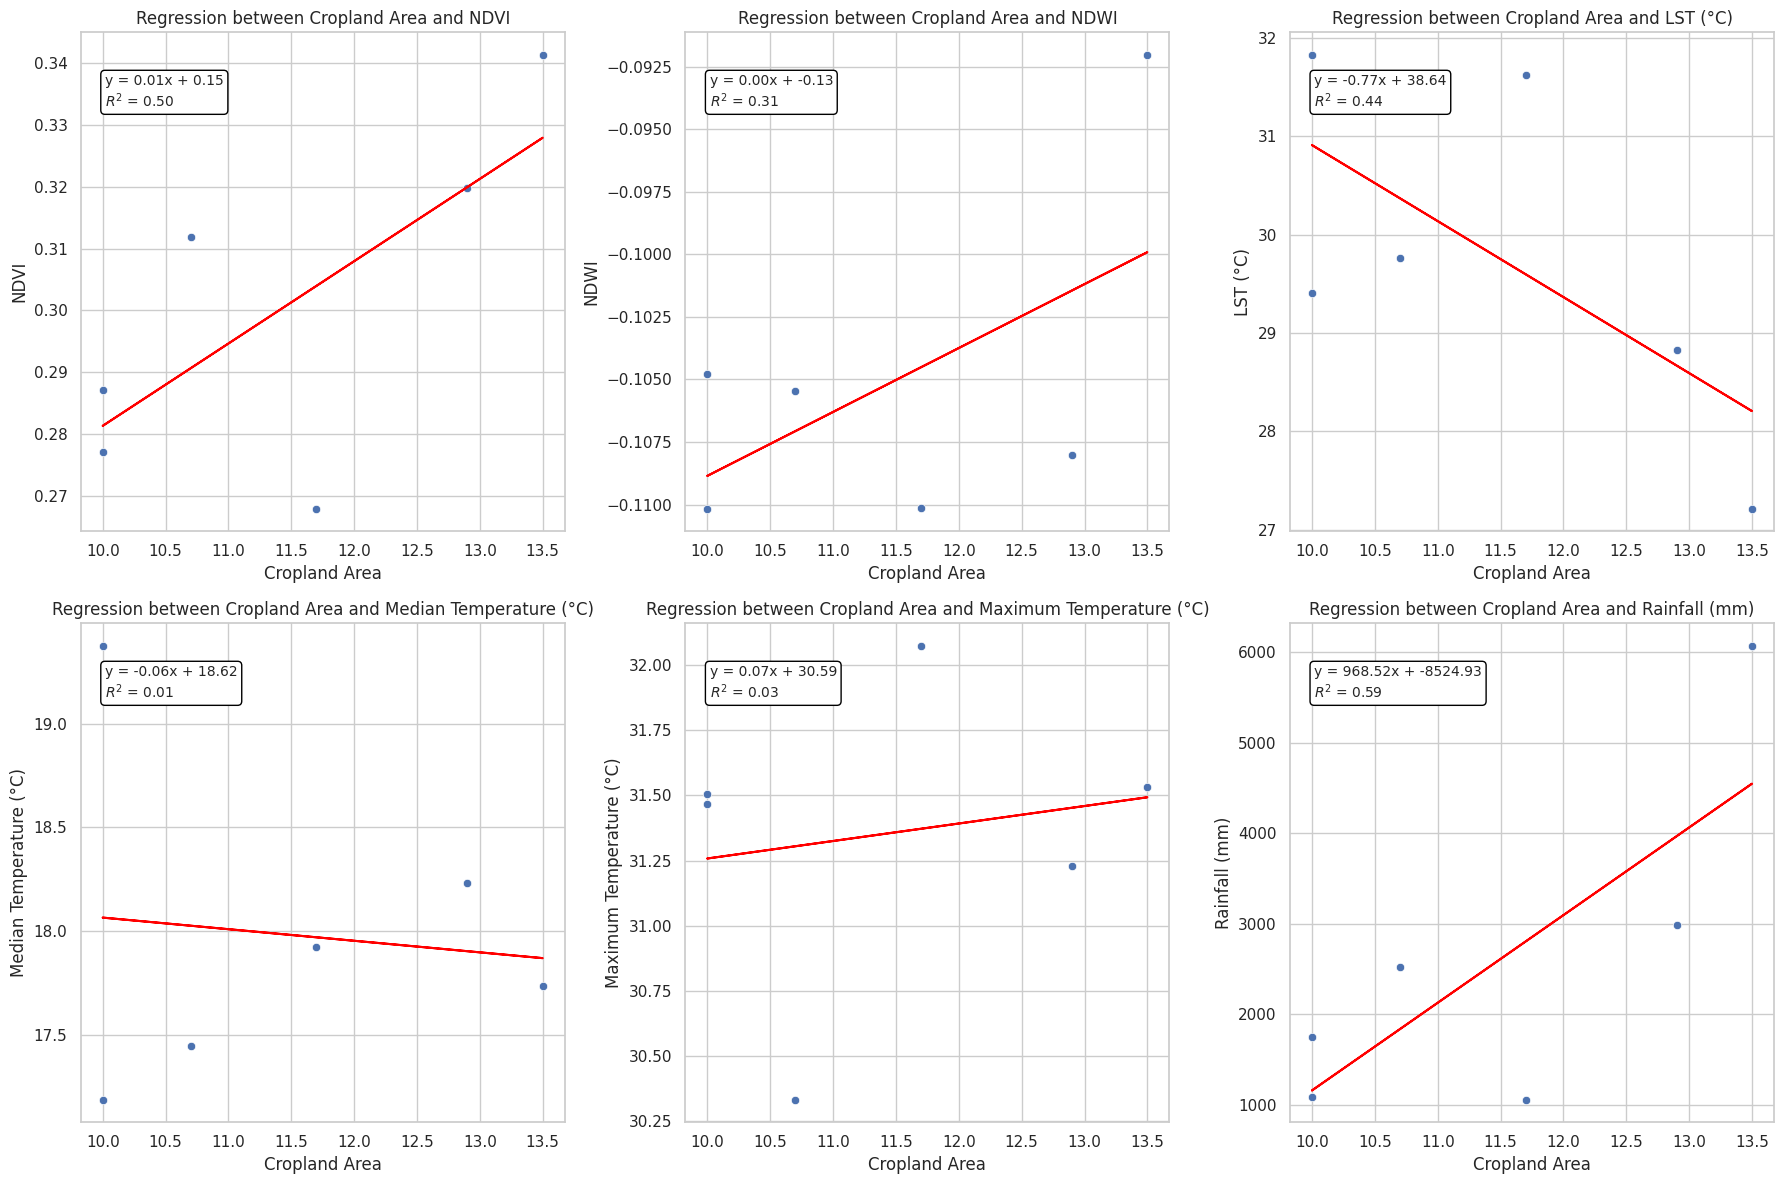

In [24]:
# Verificar que la columna 'Cropland Area' está presente
if 'Cropland Area' not in df_median.columns:
    raise KeyError("'Cropland Area' is not found in the DataFrame. Please ensure it was added correctly.")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Excluir columnas no deseadas
numeric_columns = df_median.select_dtypes(include=['float64', 'int64']).columns
exclude_columns = ['Year', 'Area', 'Month', 'Cropland Area', 'Minimum Temperature (°C)']
variables = [col for col in numeric_columns if col not in exclude_columns]

# Crear una figura con 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()  # Convertir en una lista de ejes para iterar fácilmente

# Iterar sobre las variables y los ejes
for i, variable in enumerate(variables):
    if i >= len(axes):  # Detenerse si no hay más ejes disponibles
        break

    # Preparar datos
    X = df_median['Cropland Area'].values.reshape(-1, 1)
    y = df_median[variable].values

    # Ajustar modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calcular R2
    r2 = r2_score(y, y_pred)

    # Generar gráfico
    ax = axes[i]
    sns.scatterplot(x=df_median['Cropland Area'], y=df_median[variable], ax=ax)
    ax.plot(df_median['Cropland Area'], y_pred, color='red')
    ax.set_title(f'Regression between Cropland Area and {variable}')
    ax.set_xlabel('Cropland Area')
    ax.set_ylabel(variable)

    # Añadir la ecuación y R2
    coef = model.coef_[0]
    intercept = model.intercept_
    equation = f'y = {coef:.2f}x + {intercept:.2f}\n$R^2$ = {r2:.2f}'
    ax.text(0.05, 0.85, equation, transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

# Ocultar los ejes sobrantes si hay menos de 6 gráficos
for j in range(len(variables), len(axes)):
    axes[j].axis('off')

# Ajustar diseño
plt.tight_layout()
plt.show()


**<h2>Map visualization<h2>**

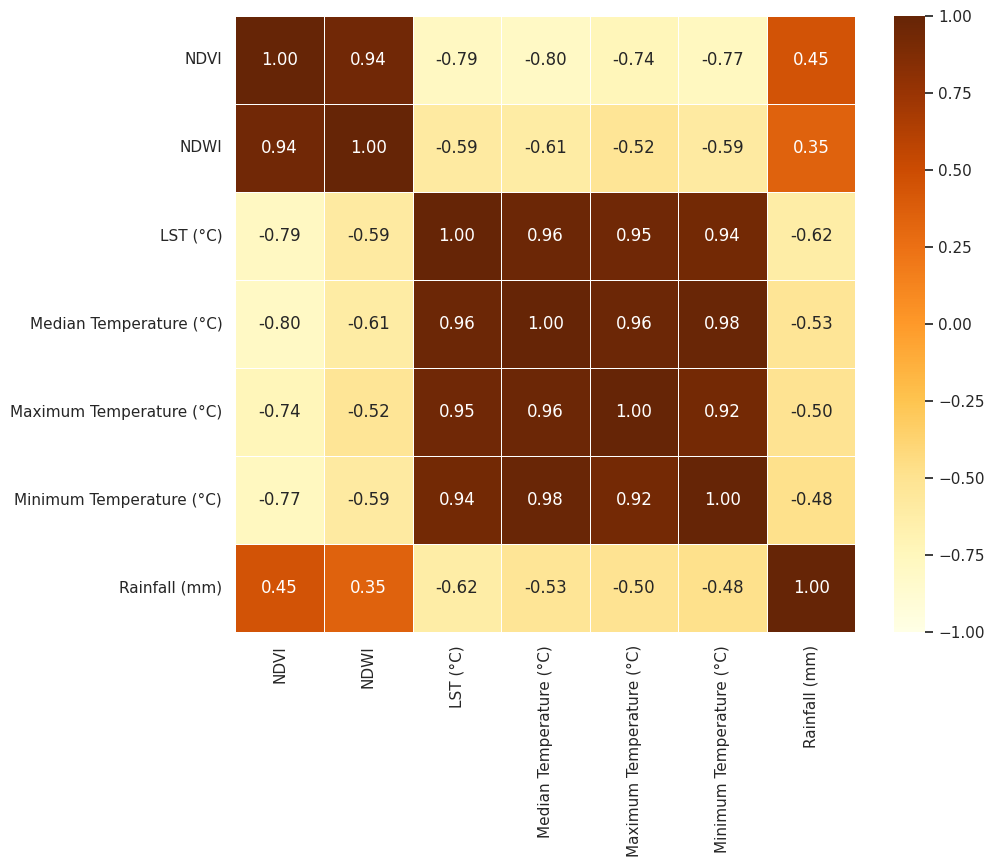

In [ ]:
# Asegúrate de que solo se incluyan las columnas numéricas
df_numeric = df_filtered.drop(columns=['Area', 'Year', 'Month','Land Use'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Crear un mapa de calor (heatmap) para la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr', vmin=-1, vmax=1, center=0, linewidths=0.5, fmt=".2f")

# Personalizar el gráfico
plt.show()


# **Sen's Slope trend**

In [ ]:
# Ruta al shapefile en tu Google Drive
shapefile_path = area

# Cargar el shapefile de Marruecos
gdf = gpd.read_file(shapefile_path)
roi = geemap.geopandas_to_ee(gdf)

# Inicializar Google Earth Engine
ee.Initialize()

# Años de análisis
start_year = 2010
end_year = 2022

# Rango de fechas
start_date = f"{start_year}-01-01"
end_date = f"{end_year}-12-31"

# Colecciones de imágenes y variables
collections = {
    "NDVI": "MODIS/061/MOD13Q1",
    "NDWI": "MODIS/MCD43A4_006_NDWI",
    "LST": "MODIS/061/MOD11A1",
    "Temperature": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
    "Max Temperature": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
    "Precipitation": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
}

bands = {
    "NDVI": "NDVI",
    "NDWI": "NDWI",
    "LST": "LST_Day_1km",
    "Temperature": "temperature_2m",
    "Max Temperature": "temperature_2m_max",
    "Precipitation": "total_precipitation_sum",
}

# Función para calcular la pendiente de tendencia por píxel
def calculate_trend_slope(collection_id, band, start_date, end_date, roi):
    collection = ee.ImageCollection(collection_id).filterDate(start_date, end_date).select(band).filterBounds(roi)

    # Añadir una propiedad de tiempo en años para calcular tendencias
    def add_time(image):
        years = ee.Date(image.get("system:time_start")).difference(ee.Date(start_date), "year")
        return image.addBands(ee.Image(years).rename("year").float())

    collection = collection.map(add_time)

    # Reducir la colección para calcular la pendiente de tendencia (slope)
    linear_fit = collection.reduce(ee.Reducer.linearFit())
    slope = linear_fit.select("scale")
    return slope.clip(roi)

# Crear un mapa para visualizar resultados
Map = geemap.Map()

# Visualización de parámetros
vis_params = {
    "NDVI": {"min": -0.05, "max": 0.05, "palette": ["blue", "white", "green"]},
    "NDWI": {"min": -0.05, "max": 0.05, "palette": ["blue", "white", "green"]},
    "LST": {"min": -0.1, "max": 0.1, "palette": ["blue", "white", "red"]},
    "Temperature": {"min": -0.1, "max": 0.1, "palette": ["blue", "white", "red"]},
    "Max Temperature": {"min": -0.1, "max": 0.1, "palette": ["blue", "white", "red"]},
    "Precipitation": {"min": -10, "max": 10, "palette": ["blue", "white", "red"]},
}

# Calcular y añadir capas para cada variable
for variable, collection_id in collections.items():
    print(f"Processing {variable}...")
    band = bands[variable]
    trend_slope = calculate_trend_slope(collection_id, band, start_date, end_date, roi)
    Map.addLayer(trend_slope, vis_params[variable], f"{variable} Trend Slope")

# Centrar el mapa y mostrar
Map.centerObject(roi, 6)
Map


Processing NDVI...
Processing NDWI...
Processing LST...
Processing Temperature...
Processing Max Temperature...
Processing Precipitation...


Map(center=[29.03784482638033, -9.155980960684186], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Ruta al shapefile en tu Google Drive
shapefile_path = area

# Cargar el shapefile de Marruecos
gdf = gpd.read_file(shapefile_path)
roi = geemap.geopandas_to_ee(gdf)

# Inicializar Google Earth Engine
ee.Initialize()

# Años de análisis
start_year = 2010
end_year = 2022

# Rango de fechas
start_date = f"{start_year}-01-01"
end_date = f"{end_year}-12-31"

# Colecciones de imágenes y variables
collections = {
    "NDVI": "MODIS/061/MOD13Q1",
    "NDWI": "MODIS/MCD43A4_006_NDWI",
    "LST": "MODIS/061/MOD11A1",
    "Temperature": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
    "Max Temperature": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
    "Precipitation": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
}

bands = {
    "NDVI": "NDVI",
    "NDWI": "NDWI",
    "LST": "LST_Day_1km",
    "Temperature": "temperature_2m",
    "Max Temperature": "temperature_2m_max",
    "Precipitation": "total_precipitation_sum",
}

# Función para calcular la pendiente de Theil-Sen (Sen's Slope) por píxel
def calculate_sens_slope(collection_id, band, start_date, end_date, roi):
    collection = ee.ImageCollection(collection_id).filterDate(start_date, end_date).select(band).filterBounds(roi)

    # Añadir una propiedad de tiempo en años para calcular tendencias
    def add_time(image):
        years = ee.Date(image.get("system:time_start")).difference(ee.Date(start_date), "year")
        return image.addBands(ee.Image(years).rename("year").float())

    collection = collection.map(add_time)

    # Crear una lista de imágenes para usar con Theil-Sen
    images = collection.toList(collection.size())
    size = images.size()

    # Calcular pendientes para todos los pares de imágenes
    def compute_slope(index1):
        img1 = ee.Image(images.get(index1))
        year1 = img1.select("year").reduceRegion(ee.Reducer.first(), roi, 500).values().get(0)

        def pair_slope(index2):
            img2 = ee.Image(images.get(index2))
            year2 = img2.select("year").reduceRegion(ee.Reducer.first(), roi, 500).values().get(0)

            # Calcular pendiente entre pares
            slope = img2.subtract(img1).divide(ee.Number(year2).subtract(year1))
            return slope.rename("slope")

        slopes = ee.List.sequence(index1.add(1), size.subtract(1)).map(pair_slope)
        return ee.ImageCollection(slopes).median()  # Mediana de las pendientes

    # Aplicar la función a cada imagen
    all_slopes = ee.List.sequence(0, size.subtract(2)).map(compute_slope)
    sens_slope = ee.ImageCollection(all_slopes).median().rename("sens_slope")

    return sens_slope.clip(roi)

# Crear un mapa para visualizar resultados
Map = geemap.Map()

# Visualización de parámetros
vis_params = {
    "NDVI": {"min": -0.05, "max": 0.05, "palette": ["blue", "white", "green"]},
    "NDWI": {"min": -0.05, "max": 0.05, "palette": ["blue", "white", "green"]},
    "LST": {"min": -0.1, "max": 0.1, "palette": ["blue", "white", "red"]},
    "Temperature": {"min": -0.1, "max": 0.1, "palette": ["blue", "white", "red"]},
    "Max Temperature": {"min": -0.1, "max": 0.1, "palette": ["blue", "white", "red"]},
    "Precipitation": {"min": -10, "max": 10, "palette": ["blue", "white", "red"]},
}

# Calcular y añadir capas para cada variable
for variable, collection_id in collections.items():
    print(f"Processing {variable}...")
    band = bands[variable]
    sens_slope = calculate_sens_slope(collection_id, band, start_date, end_date, roi)
    Map.addLayer(sens_slope, vis_params[variable], f"{variable} Sen's Slope")

# Centrar el mapa y mostrar
Map.centerObject(roi, 6)
Map


TimeoutException: Requesting secret GOOGLE_MAPS_API_KEY timed out. Secrets can only be fetched when running from the Colab UI.

In [ ]:
# Cargar el shapefile de Marruecos
gdf = gpd.read_file(area)
roi = geemap.geopandas_to_ee(gdf)

# Años de análisis
start_year = 2010
end_year = 2022

# Rango de fechas
start_date = f"{start_year}-01-01"
end_date = f"{end_year}-12-31"

# Colecciones de imágenes y variables
collections = {
    "NDVI": "MODIS/061/MOD13Q1",
    "NDWI": "MODIS/MCD43A4_006_NDWI",
    "LST": "MODIS/061/MOD11A1",
    "Temperature": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
    "Max Temperature": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
    "Precipitation": "ECMWF/ERA5_LAND/MONTHLY_AGGR",
}

bands = {
    "NDVI": "NDVI",
    "NDWI": "NDWI",
    "LST": "LST_Day_1km",
    "Temperature": "temperature_2m",
    "Max Temperature": "temperature_2m_max",
    "Precipitation": "total_precipitation_sum",
}

# Función para calcular el coeficiente de variación
def calculate_cv(collection_id, band, start_date, end_date, roi):
    collection = ee.ImageCollection(collection_id).filterDate(start_date, end_date).select(band).filterBounds(roi)

    # Calcular la media y la desviación estándar
    mean_image = collection.reduce(ee.Reducer.mean())
    std_dev_image = collection.reduce(ee.Reducer.stdDev())

    # Calcular el coeficiente de variación en porcentaje
    cv = std_dev_image.divide(mean_image).multiply(100)
    return cv.clip(roi)

# Función para exportar imágenes a GeoTIFF en Google Drive
def export_to_geotiff(image, description, folder, region, scale=500):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        region=region,
        scale=scale,
        maxPixels=1e13,
        crs="EPSG:4326"
    )
    task.start()
    print(f"Exporting {description} to Google Drive folder '{folder}'...")

# Crear un mapa para visualizar resultados
Map = geemap.Map()

# Visualización de parámetros
cv_vis_params = {
    "NDVI": {"min": 0, "max": 100, "palette": ["blue", "white", "red"]},
    "NDWI": {"min": 0, "max": 100, "palette": ["blue", "white", "red"]},
    "LST": {"min": 0, "max": 100, "palette": ["blue", "white", "red"]},
    "Temperature": {"min": 0, "max": 100, "palette": ["blue", "white", "red"]},
    "Max Temperature": {"min": 0, "max": 100, "palette": ["blue", "white", "red"]},
    "Precipitation": {"min": 0, "max": 100, "palette": ["blue", "white", "red"]},
}

# Carpeta de exportación en Google Drive
export_folder = "EarthEngine_Exports"

# Exportar y añadir capas al mapa
for variable, collection_id in collections.items():
    print(f"Processing {variable}...")
    band = bands[variable]
    cv_image = calculate_cv(collection_id, band, start_date, end_date, roi)

    # Añadir al mapa
    Map.addLayer(cv_image, cv_vis_params[variable], f"{variable} Coefficient of Variation")

    # Exportar a GeoTIFF
    export_to_geotiff(
        image=cv_image,
        description=f"{variable}_CV",
        folder=export_folder,
        region=gdf.total_bounds.tolist(),  # Bounding box del shapefile
        scale=500
    )

# Centrar el mapa y mostrar
Map.centerObject(roi, 6)
Map


Processing NDVI...
Exporting NDVI_CV to Google Drive folder 'EarthEngine_Exports'...
Processing NDWI...
Exporting NDWI_CV to Google Drive folder 'EarthEngine_Exports'...
Processing LST...
Exporting LST_CV to Google Drive folder 'EarthEngine_Exports'...
Processing Temperature...
Exporting Temperature_CV to Google Drive folder 'EarthEngine_Exports'...
Processing Max Temperature...
Exporting Max Temperature_CV to Google Drive folder 'EarthEngine_Exports'...
Processing Precipitation...
Exporting Precipitation_CV to Google Drive folder 'EarthEngine_Exports'...


Map(center=[29.03784482638033, -9.155980960684186], controls=(WidgetControl(options=['position', 'transparent_…